In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as st
import seaborn.objects as so
import seaborn as sns

In [2]:
palette = ['#7a5195', '#ef5675', '#ffa600'] #https://matplotlib.org/stable/gallery/color/named_colors.html
marker_size = 8  # Ustalony rozmiar markerów
xlabel = "Distance beetwen AP and STAs [m]"

In [3]:
data = pd.read_csv('MLOn1.csv').drop_duplicates()
data

,rngRun,flow,nStations,distance,linksNumber,loss,jitter,latency,throughput,rxBytes,...,txPackets,timeFirstRxPacket,timeFirstTxPacket,timeLastRxPacket,timeLastTxPacket,jitterSum,delaySum,rateAdaptationManager,scenario,MLOn
0,407456,1,1,1,2,71.3242,0.000547,2.13666,30.6917,482601992,...,1101413,1.03377,1.03377,121.000,121.000,172.809,674841.0,ns3::ThompsonSamplingWifiManager,B,0
1,407456,2,1,1,2,71.3454,0.000547,2.13914,30.6654,482244440,...,1101413,1.01367,1.01367,120.994,120.994,172.542,675122.0,ns3::ThompsonSamplingWifiManager,B,0
2,407456,3,1,1,2,71.2597,0.000544,2.13545,30.7564,483686872,...,1101413,1.01721,1.01721,121.000,121.000,172.240,675973.0,ns3::ThompsonSamplingWifiManager,B,0
3,407456,4,1,1,2,71.0656,0.000540,2.12394,30.9651,486953736,...,1101413,1.01905,1.01905,120.998,120.998,171.996,676873.0,ns3::ThompsonSamplingWifiManager,B,0
4,407456,1,1,1,2,71.3219,0.000546,2.13618,30.6965,482640192,...,1101413,1.02326,1.02326,120.980,120.980,172.559,674742.0,ns3::ThompsonSamplingWifiManager,C,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,319,4,1,1,2,71.5362,0.000552,2.14593,30.4592,479034112,...,1101413,1.01087,1.01087,120.999,120.999,173.012,672759.0,ns3::ThompsonSamplingWifiManager,C,0
812,319,1,1,1,3,71.6333,0.000554,2.14982,30.3675,477400680,...,1101413,1.05990,1.05990,121.000,121.000,173.000,671679.0,ns3::ThompsonSamplingWifiManager,D,0
813,319,2,1,1,3,71.2582,0.000544,2.13676,30.7620,483712848,...,1101413,1.01313,1.01313,120.981,120.981,172.273,676425.0,ns3::ThompsonSamplingWifiManager,D,0
814,319,3,1,1,3,71.2424,0.000544,2.13034,30.7783,483978720,...,1101413,1.03010,1.03010,121.000,121.000,172.330,674765.0,ns3::ThompsonSamplingWifiManager,D,0


In [4]:
# Utwórz kolumny logiczne
data = data.copy()
data['flow_leq_MLOn'] = data['flow'] <= data['MLOn']
data['flow_gt_MLOn'] = data['flow'] > data['MLOn']

In [5]:
df0 = (
    data[data['flow_leq_MLOn']]
    .groupby(['scenario', 'distance', 'linksNumber', 'rngRun', 'MLOn'], as_index=False)
    .mean(numeric_only=True)
    .assign(flow='≤MLOn')
)

df1 = (
    data[data['flow_gt_MLOn']]
    .groupby(['scenario', 'distance', 'linksNumber', 'rngRun', 'MLOn'], as_index=False)
    .mean(numeric_only=True)
    .assign(flow='>MLOn')
)

#  Suma flow 0 + 1
df_sum = (
    data
        .groupby(['scenario', 'distance', 'linksNumber', 'rngRun', 'MLOn'], as_index=False)
        .mean(numeric_only=True)
        .assign(flow='1+2')                       # sztuczna etykieta – tylko żeby było wiadomo
)

In [6]:
df_sum

,scenario,distance,linksNumber,rngRun,MLOn,flow,nStations,loss,jitter,latency,...,rxPackets,txPackets,timeFirstRxPacket,timeFirstTxPacket,timeLastRxPacket,timeLastTxPacket,jitterSum,delaySum,flow_leq_MLOn,flow_gt_MLOn
0,B,1,2,300,0,1+2,1.0,71.300425,0.000546,2.135175,...,316100.75,1101413.0,1.026120,1.026120,120.99350,120.99350,172.455250,674881.50,0.00,1.00
1,B,1,2,301,0,1+2,1.0,71.367450,0.000547,2.138685,...,315362.75,1101413.0,1.036717,1.036717,120.99375,120.99375,172.467000,674456.50,0.00,1.00
2,B,1,2,302,0,1+2,1.0,71.350150,0.000547,2.138450,...,315553.00,1101413.0,1.022518,1.022518,120.99575,120.99575,172.638500,674790.50,0.00,1.00
3,B,1,2,303,0,1+2,1.0,71.305100,0.000546,2.135985,...,316049.50,1101413.0,1.031030,1.031030,120.98800,120.98800,172.494750,675063.75,0.00,1.00
4,B,1,2,304,0,1+2,1.0,71.238575,0.000544,2.133017,...,316782.25,1101413.0,1.024722,1.024722,120.99625,120.99625,172.372000,675691.50,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,D,1,3,407482,3,1+2,1.0,25.496925,0.000086,1.091260,...,820586.50,1101413.0,1.005918,1.005918,120.99975,120.99975,69.149975,887593.25,0.75,0.25
200,D,1,3,407482,4,1+2,1.0,24.480175,0.000081,1.114718,...,831785.25,1101413.0,1.006613,1.006613,121.00000,121.00000,67.305575,927189.25,1.00,0.00
201,D,1,3,407483,0,1+2,1.0,71.287750,0.000545,2.135413,...,316240.25,1101413.0,1.026642,1.026642,120.99650,120.99650,172.477000,675288.75,0.00,1.00
202,D,1,3,407483,1,1+2,1.0,49.022122,0.000302,1.421718,...,561477.00,1101413.0,1.020840,1.020840,120.99675,120.99675,122.454600,581636.25,0.25,0.75


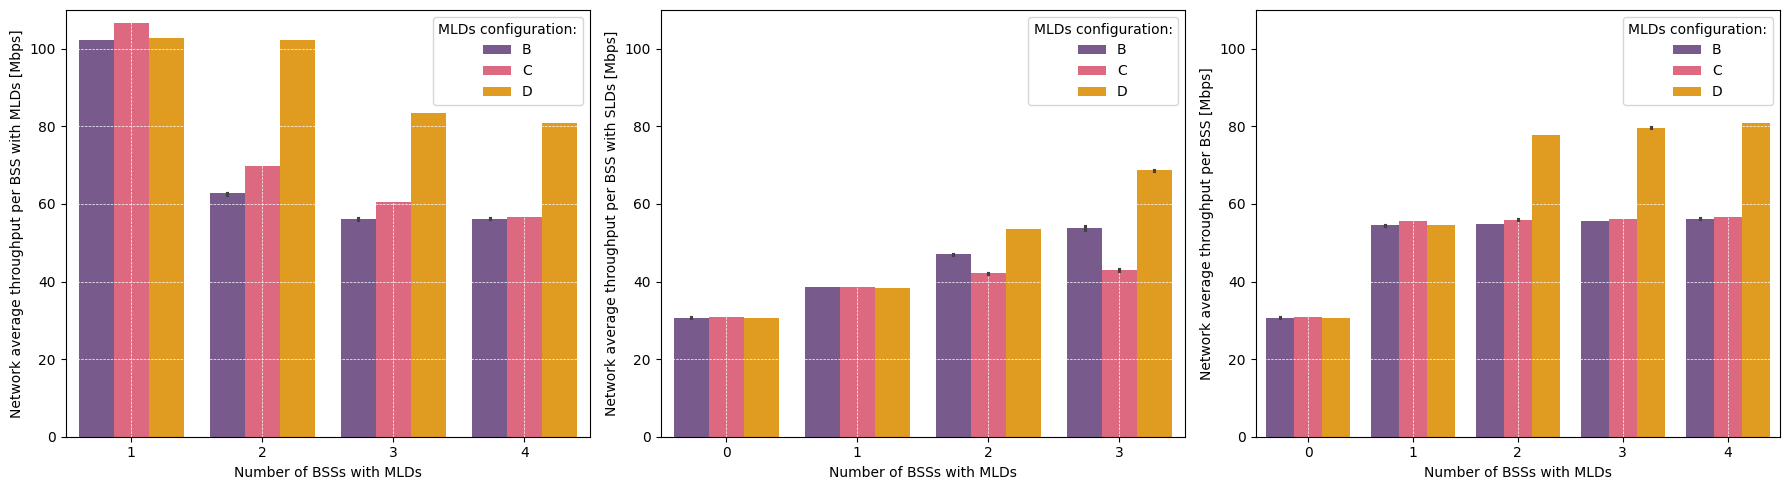

In [7]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Number of BSSs with MLDs"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Network average throughput per BSS with MLDs [Mbps]'),
    (df1, 'Network average throughput per BSS with SLDs [Mbps]'),
    (df_sum, 'Network average throughput per BSS [Mbps]')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.barplot(data=df, x='MLOn', y='throughput', hue='scenario',
                 errorbar=('ci'), palette=palette,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[0:7],  # Przytnij, jeśli trzeba
        labels=['B', 'C', 'D'],  # Twoje etykiety
        ncol=1,
        fontsize='medium',   # Rozmiar czcionki
       title='MLDs configuration:',         # <- Tytuł legendy
       title_fontsize='medium'    # <- Rozmiar czcionki tytułu
    )

    axes[i].set(xlabel=xlabel, ylabel=title)
    if i != 2:
        axes[i].set_ylim(0, 110)
    else:
        axes[i].set_ylim(0, 110) #, 225
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_thr_flows3.svg', bbox_inches='tight')
plt.show()

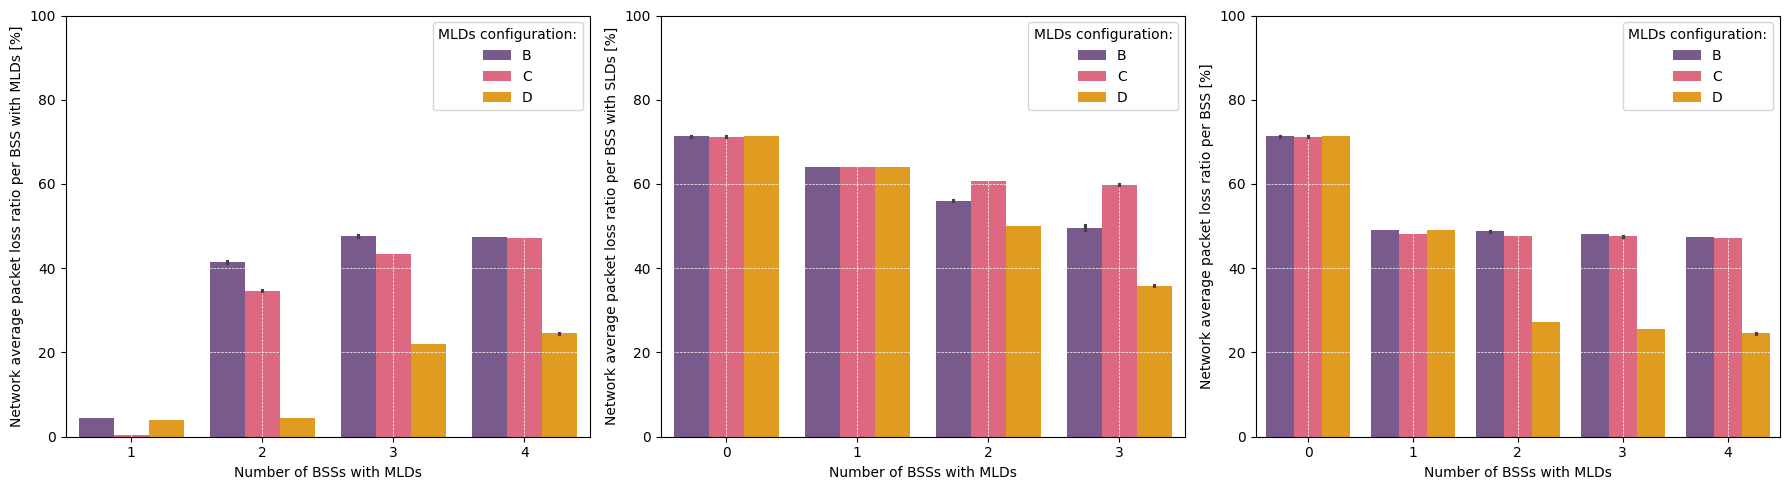

In [8]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Number of BSSs with MLDs"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Network average packet loss ratio per BSS with MLDs [%]'),
    (df1, 'Network average packet loss ratio per BSS with SLDs [%]'),
    (df_sum, 'Network average packet loss ratio per BSS [%]')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.barplot(data=df, x='MLOn', y='loss', hue='scenario',
                 errorbar=('ci'), palette=palette,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[0:7],  # Przytnij, jeśli trzeba
        labels=['B', 'C', 'D'],  # Twoje etykiety
        ncol=1,
        fontsize='medium',   # Rozmiar czcionki
       title='MLDs configuration:',         # <- Tytuł legendy
       title_fontsize='medium'    # <- Rozmiar czcionki tytułu
    )

    axes[i].set(xlabel=xlabel, ylabel=title)
    if i != 2:
        axes[i].set_ylim(0, 100)
    else:
        axes[i].set_ylim(0, 100) #, 225
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_loss_flows3.svg', bbox_inches='tight')
plt.show()

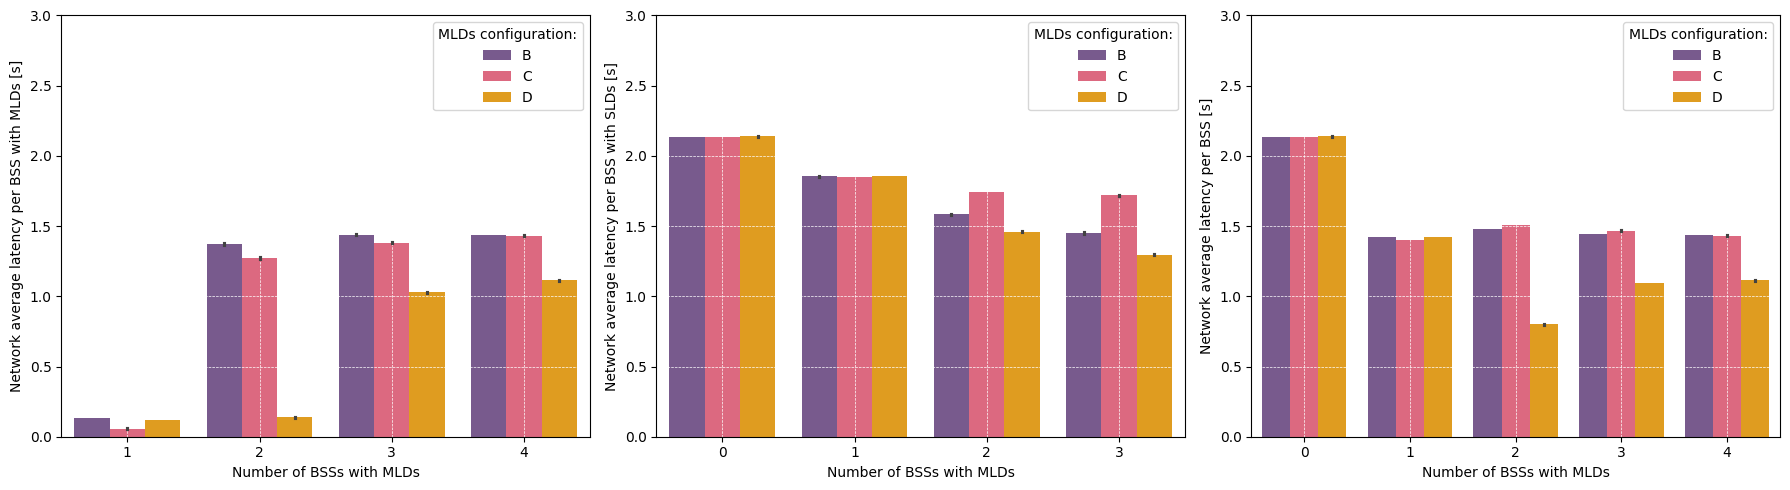

In [9]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Number of BSSs with MLDs"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Network average latency per BSS with MLDs [s]'),
    (df1, 'Network average latency per BSS with SLDs [s]'),
    (df_sum, 'Network average latency per BSS [s]')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.barplot(data=df, x='MLOn', y='latency', hue='scenario',
                 errorbar=('ci'), palette=palette,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[0:7],  # Przytnij, jeśli trzeba
        labels=['B', 'C', 'D'],  # Twoje etykiety
        ncol=1,
        fontsize='medium',   # Rozmiar czcionki
       title='MLDs configuration:',         # <- Tytuł legendy
       title_fontsize='medium'    # <- Rozmiar czcionki tytułu
    )

    axes[i].set(xlabel=xlabel, ylabel=title)
    if i != 2:
        axes[i].set_ylim(0, 3)
    else:
        axes[i].set_ylim(0, 3) #, 225
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_latency_flows3.svg', bbox_inches='tight')
plt.show()

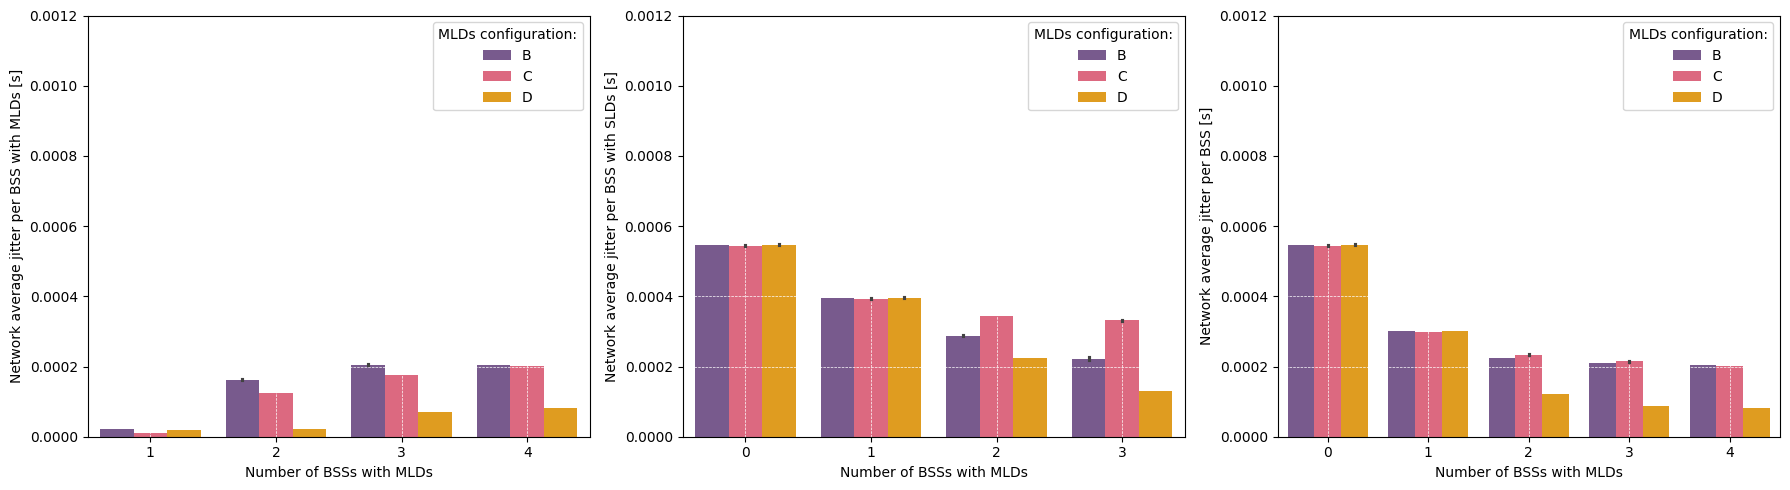

In [10]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Number of BSSs with MLDs"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Network average jitter per BSS with MLDs [s]'),
    (df1, 'Network average jitter per BSS with SLDs [s]'),
    (df_sum, 'Network average jitter per BSS [s]')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.barplot(data=df, x='MLOn', y='jitter', hue='scenario',
                 errorbar=('ci'), palette=palette,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[0:7],  # Przytnij, jeśli trzeba
        labels=['B', 'C', 'D'],  # Twoje etykiety
        ncol=1,
        fontsize='medium',   # Rozmiar czcionki
       title='MLDs configuration:',         # <- Tytuł legendy
       title_fontsize='medium'    # <- Rozmiar czcionki tytułu
    )

    axes[i].set(xlabel=xlabel, ylabel=title)
    if i != 2:
        axes[i].set_ylim(0, 0.0012)
    else:
        axes[i].set_ylim(0, 0.0012) #, 225
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_jitter_flows3.svg', bbox_inches='tight')
plt.show()